In [1]:
import numpy as np
import config.config as config
from Agent import *
from Model import *
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.signal import savgol_filter
from scipy.stats import sem, bootstrap
from sklearn.linear_model import RidgeCV

In [2]:
class Env():
    def __init__(self, gamma_shape=10):
        self.gamma_shape = gamma_shape
        self.gamma_mus = np.array([3, 6, 9])
        self.batch_size = arg.batch_size
        
    def reset(self, obs_std):
        self.box_time_count = np.zeros((self.batch_size, self.gamma_mus.size + 1))
        self.box_mus = np.ones((self.batch_size, self.gamma_mus.size))
        self.box_sampled_interval = np.ones_like(self.box_time_count) * 10000
        for trial_idx in range(self.batch_size):
            #self.box_mus[trial_idx] = np.random.permutation(self.gamma_mus)
            # no need to shuffle boxes for analysis
            self.box_mus[trial_idx] = self.gamma_mus
        
        self.box_sampled_interval[:, :self.gamma_mus.size] = np.round(np.random.gamma(shape=self.gamma_shape, 
                                                                      scale=self.box_mus / self.gamma_shape))
        #self.obs_std = np.random.rand(self.batch_size, 1) * 1
        # fix a observation noise std
        self.obs_std = np.ones((self.batch_size, 1)) * obs_std
        
    def get_obs(self):
        obs = (self.box_time_count / self.box_sampled_interval)[:, :self.gamma_mus.size].clip(0, 1)
        obs += obs * np.random.randn(*obs.shape) * self.obs_std
        obs = np.concatenate([obs, self.obs_std], axis=-1)
        return obs
    
    def get_true_obs(self):
        obs = (self.box_time_count / self.box_sampled_interval)[:, :self.gamma_mus.size].clip(0, 1)
        return obs
        
    def push_button(self, box_idx):
        reward = self.box_time_count[np.arange(box_idx.size), box_idx] >= \
                 self.box_sampled_interval[np.arange(box_idx.size), box_idx]
        reward = reward.astype(float)
        
        cost = -np.ones_like(reward) * 0.01
        cost[box_idx == 3] = 0
        
        
        self.box_time_count += 1 
        self.box_time_count[np.arange(box_idx.size), box_idx] = 0
        self.box_sampled_interval[box_idx != 3, box_idx[box_idx != 3]] = np.round(
                                np.random.gamma(shape=self.gamma_shape, 
                                                scale=self.box_mus[box_idx != 3, box_idx[box_idx != 3]]
                                                / self.gamma_shape)).clip(1, 10000)
        return reward+cost, reward+cost

In [3]:
# params
seed_number = 0
# select stored agent path
datapath = Path(rf'C:\Users\Panos\OneDrive - nyu.edu\Documents\PhD Classes\Machine Learning\ML_Project\Code\seed0')
arg = config.ConfigCore(datapath)
arg.SEED_NUMBER = seed_number
arg.device = 'cpu'

# reproducibility
torch.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number)
np.random.seed(seed_number)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
agent = Agent(arg, ActorCritic)

In [5]:
agent.load('20231106-211552-370', load_optimzer=False)

In [6]:
def simulate(obs_std):
    num_trial = 1
    test = []

    reward_log = reward_num = done_num = 0
    agent.buffer.clear()

    def get_init_variables():   
        state = torch.zeros(1, arg.batch_size, 7, device=arg.device)
        hiddenin = (torch.zeros(1, arg.batch_size, arg.RNNSELF_SIZE, device=arg.device),
                    torch.zeros(1, arg.batch_size, arg.RNNSELF_SIZE, device=arg.device))

        return state, hiddenin

    state, hiddenin = get_init_variables()
    env.reset(obs_std)
    true_state = env.get_true_obs()
    true_state = torch.tensor(true_state, device=arg.device, dtype=torch.float).unsqueeze(0)

    for i_epi in range(num_trial):
        agent.buffer.actorhidden0s.append(hiddenin)

        state_vectors = []; states = []; actions = []; actionlogprobs = []; rewards = []
        true_states = []

        for t in range(arg.truncated_len):
            action, action_logprob, hiddenout, dist = agent.select_action(state, hiddenin, 
                                                                          enable_noise=True, return_dist=True)
            test.append(dist.entropy().mean())
            action_cpu = action.cpu().squeeze().numpy()
            reward_shaped, reward = env.push_button(action_cpu)
            reward_shaped = torch.tensor(reward_shaped, device=arg.device, 
                                         dtype=torch.float).reshape(1, -1, 1) * arg.REWARD_SCALE
            reward = torch.tensor(reward, device=arg.device, dtype=torch.float).reshape(1, -1, 1)
            # store stuff
            reward_log += reward.mean()
            reward_num += reward.sum()

            true_states.append(true_state)
            states.append(state)
            actions.append(action)
            actionlogprobs.append(action_logprob)
            rewards.append(reward_shaped)

            # next step
            next_obs = env.get_obs()
            next_obs = torch.tensor(next_obs, device=arg.device, dtype=torch.float).unsqueeze(0)
            next_state = torch.cat([next_obs, action / 3, reward, torch.ones_like(reward) * t / 1000], dim=-1)
            next_true_state = env.get_true_obs()
            next_true_state = torch.tensor(next_true_state, device=arg.device, dtype=torch.float).unsqueeze(0)

            # update variables
            hiddenin = hiddenout
            state = next_state
            true_state = next_true_state

        states = torch.cat(states)
        actions = torch.cat(actions)
        actionlogprobs = torch.cat(actionlogprobs)
        rewards = torch.cat(rewards)
        true_states = torch.cat(true_states)


        reward_frac = (reward_num.item()) / (arg.batch_size * arg.full_len)

        print(f'epi {i_epi},', f'reward_avg {reward_log.item(): .3f},', f'reward_num {reward_num.item(): .0f},',
              f'reward_frac {reward_frac: .3f}')

        reward_log = 0
        reward_num = 0
        done_num = 0
        
        return {'states': states, 'actions': actions, 'actionlogprobs': actionlogprobs, 
                'rewards': rewards, 'true_states': true_states, }

In [7]:
# simulate multiple sessions with increasing observation noise stds
obs_stds = np.round(np.linspace(0, 2, 11), 1)
env = Env(gamma_shape=10)
data = {}
for obs_std in obs_stds:
    data[obs_std] = simulate(obs_std)

epi 0, reward_avg  429.702, reward_num  214851, reward_frac  0.430
epi 0, reward_avg  409.816, reward_num  204908, reward_frac  0.410
epi 0, reward_avg  378.353, reward_num  189177, reward_frac  0.378
epi 0, reward_avg  350.609, reward_num  175305, reward_frac  0.351
epi 0, reward_avg  325.837, reward_num  162918, reward_frac  0.326
epi 0, reward_avg  305.030, reward_num  152515, reward_frac  0.305
epi 0, reward_avg  287.084, reward_num  143542, reward_frac  0.287
epi 0, reward_avg  273.804, reward_num  136902, reward_frac  0.274
epi 0, reward_avg  262.579, reward_num  131290, reward_frac  0.263
epi 0, reward_avg  253.545, reward_num  126773, reward_frac  0.254
epi 0, reward_avg  246.459, reward_num  123230, reward_frac  0.246


In [8]:
env = Env(gamma_shape=100000000)
data_delta = {}
for obs_std in obs_stds:
    data_delta[obs_std] = simulate(obs_std)

epi 0, reward_avg  446.044, reward_num  223022, reward_frac  0.446
epi 0, reward_avg  431.387, reward_num  215694, reward_frac  0.431
epi 0, reward_avg  397.241, reward_num  198621, reward_frac  0.397
epi 0, reward_avg  364.347, reward_num  182174, reward_frac  0.364
epi 0, reward_avg  335.164, reward_num  167582, reward_frac  0.335
epi 0, reward_avg  309.452, reward_num  154726, reward_frac  0.309
epi 0, reward_avg  288.537, reward_num  144268, reward_frac  0.289
epi 0, reward_avg  272.386, reward_num  136193, reward_frac  0.272
epi 0, reward_avg  259.153, reward_num  129577, reward_frac  0.259
epi 0, reward_avg  250.082, reward_num  125041, reward_frac  0.250
epi 0, reward_avg  241.841, reward_num  120921, reward_frac  0.242


In [9]:
box_cs = ['C0', 'C1', 'C2']

In [10]:
reward_boundary = 65; DT = 0.1
gain_lin = 200; gain_ang = 90; gain_eyehor = gain_eyever = 150
target_radius_max = 400; target_angle_max = 35
agent_height = 20; monkey_height = 10
yscale = 7 / 3

colors = {'monkB_c': 'lightseagreen', 'monkQ_c': 'salmon','monkS_c': 'saddlebrown',
          'reward_c': 'rosybrown', 'unreward_c': 'dodgerblue', }
locals().update(colors)

def my_tickformatter(value, pos):
    if abs(value) > 0 and abs(value) < 1:
        value = str(value).replace('0.', '.')
    elif value == 0:
        value = 0
    elif int(value) == value:
        value = int(value)
    return value

major_formatter = FuncFormatter(my_tickformatter)

plt.rcParams['pdf.fonttype'] = '42'
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['mathtext.default'] = 'it'
plt.rcParams['mathtext.fontset'] = 'custom'
fontsize = 7
lw = 1

# figure path
figure_path = Path('C:/Users/rz31/Desktop/arena_figure/raw')

# 2a

In [11]:
PI = {}
for obs_std in obs_stds:
    pi_box = []
    for box_idx in range(3):
        pi_session = []
        for session_idx in range(arg.batch_size):
            pt = np.where(data[obs_std]['actions'][:, session_idx].reshape(-1).numpy() == box_idx)[0]
            pi = np.diff(pt)
            pi_session.append(pi)
        pi_box.append(pi_session)
    PI[obs_std] = pi_box

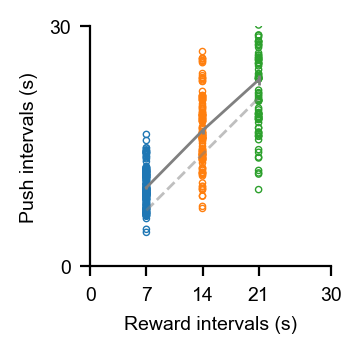

In [12]:
# no obs noise
session_idx = 0; obs_std = 0.
width = 1.6; height = 1.6
yticks = [0, 30]
xticks = [0, 7, 14, 21, 30]
RI = [7, 14, 21]

fig = plt.figure(figsize=(width, height), dpi=200)
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Push intervals (s)', fontsize=fontsize)
ax.set_xlabel('Reward intervals (s)', fontsize=fontsize)
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)
#ax.yaxis.set_label_coords(-0.17, 0.5)
#ax.xaxis.set_label_coords(0.5, -0.17)

ymean = []; ysem = []
for (box_idx, ri), box_c in zip(enumerate(RI), box_cs):
    ydata = (PI[obs_std][box_idx][session_idx] * yscale)
    ydata = ydata[np.where(ydata > ydata.mean() - 2.5* ydata.std())]
    ydata += np.random.randn(*ydata.shape) * 0.5
    ymean.append(ydata.mean()); ysem.append(sem(ydata))
    xdata = np.ones_like(ydata) * ri
    ax.scatter(xdata, ydata, ec=box_c, fc='None', s=5, lw=0.5)
    
ax.errorbar(RI, ymean, ysem, lw=1, c='gray')
ax.plot([7, 21], [7, 21], lw=lw, c='gray', alpha=0.5, ls='--')

    
fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / '{name}.pdf'.format(name='monk_agent_steer_corr'), orientation='landscape', format='pdf', 
#            transparent=True)

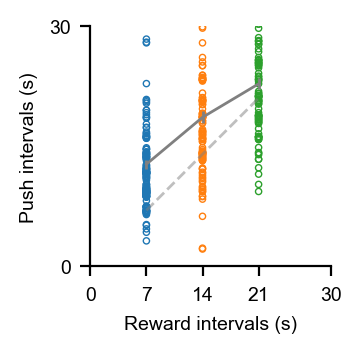

In [13]:
# large obs noise
session_idx = 12; obs_std = 1.2
width = 1.6; height = 1.6
yticks = [0, 30]
xticks = [0, 7, 14, 21, 30]
RI = [7, 14, 21]

fig = plt.figure(figsize=(width, height), dpi=200)
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Push intervals (s)', fontsize=fontsize)
ax.set_xlabel('Reward intervals (s)', fontsize=fontsize)
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)
#ax.yaxis.set_label_coords(-0.17, 0.5)
#ax.xaxis.set_label_coords(0.5, -0.17)

ymean = []; ysem = []
for (box_idx, ri), box_c in zip(enumerate(RI), box_cs):
    ydata = (PI[obs_std][box_idx][session_idx] * yscale)
    ydata = ydata[np.where(ydata > ydata.mean() - 2.5* ydata.std())]
    ydata += np.random.randn(*ydata.shape) * 0.5
    ymean.append(ydata.mean()); ysem.append(sem(ydata))
    xdata = np.ones_like(ydata) * ri
    ax.scatter(xdata, ydata, ec=box_c, fc='None', s=5, lw=0.5)
    
ax.errorbar(RI, ymean, ysem, lw=1, c='gray')
ax.plot([7, 21], [7, 21], lw=lw, c='gray', alpha=0.5, ls='--')

    
fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / '{name}.pdf'.format(name='monk_agent_steer_corr'), orientation='landscape', format='pdf', 
#            transparent=True)

# 2c

In [14]:
reward_frac = {}
for obs_std in obs_stds:
    rf_session = []
    for session_idx in range(arg.batch_size):
        r = data[obs_std]['rewards'][:, session_idx, 0].numpy()
        a = data[obs_std]['actions'][:, session_idx, 0].numpy()
        r = r[a != 3]
        rf = (r > 9).sum() / r.size
        rf_session.append(rf)
    reward_frac[obs_std] = np.array(rf_session)

<ErrorbarContainer object of 3 artists>

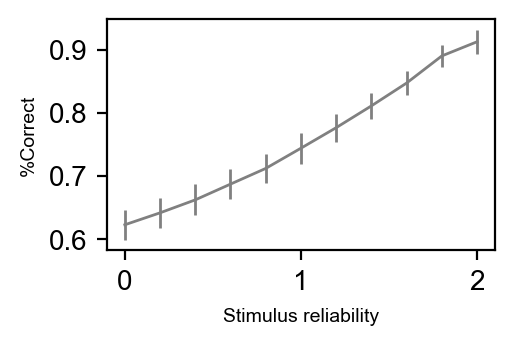

In [44]:
width = 2.5; height = 1.5
#yticks = [0, 0.5, 1]
#xticks = [0, 1, 2]

fig = plt.figure(figsize=(width, height), dpi=200)
ax = fig.add_subplot(111)
#ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
#plt.xticks(xticks, xticks, fontsize=fontsize)
#plt.yticks( fontsize=fontsize)
ax.set_ylabel('%Correct', fontsize=fontsize)
ax.set_xlabel('Stimulus reliability', fontsize=fontsize)
ax.set_xlim(0-0.1, xticks[-1]+0.1)
#ax.set_ylim(0-0.1, 1)
#ax.yaxis.set_label_coords(-0.17, 0.5)
#ax.xaxis.set_label_coords(0.5, -0.17)
#ax.yaxis.set_major_formatter(major_formatter)

ydata = [reward_frac[obs_std] for obs_std in obs_stds[::-1]]
ymean = [d.mean() for d in ydata]
ysem = [np.std(d) for d in ydata]
ax.errorbar(obs_stds, ymean, ysem, lw=1, c='gray')
    
#fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / '{name}.pdf'.format(name='monk_agent_steer_corr'), orientation='landscape', format='pdf', 
#            transparent=True)

In [51]:
import scipy.io
mat_dict = {'x_prcCorrect': obs_stds, 'y_prcCorrect': ymean, 'sem_prcCorrect': ysem}
scipy.io.savemat('prc_correct.mat', mat_dict)

# 2d

In [52]:
SI = {}
for obs_std in obs_stds:
    si_session = []
    for session_idx in range(arg.batch_size):
        si_box = []
        for box_idx in range(3):
            pt = np.where(data[obs_std]['actions'][:, session_idx].reshape(-1).numpy() == box_idx)[0]
            pi = np.diff(pt)
            si_box.append(np.mean(pi))
        si_box = np.sort(si_box)
        si_session.append(si_box[2] - si_box[0])
    SI[obs_std] = np.array(si_session)

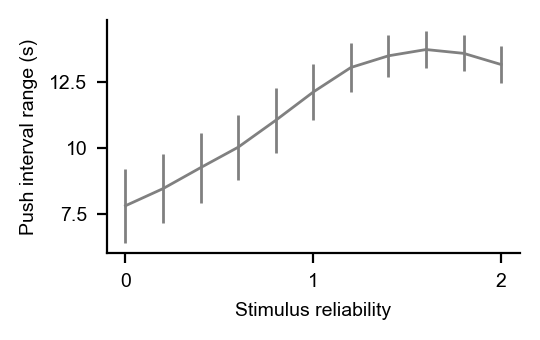

In [53]:
width = 2.5; height = 1.5
yticks = [0, 0.5, 1]
xticks = [0, 1, 2]

fig = plt.figure(figsize=(width, height), dpi=200)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticks, fontsize=fontsize)
plt.yticks( fontsize=fontsize)
ax.set_ylabel('Push interval range (s)', fontsize=fontsize)
ax.set_xlabel('Stimulus reliability', fontsize=fontsize)
ax.set_xlim(0-0.1, xticks[-1]+0.1)
#ax.set_ylim(0-0.1, 1)
#ax.yaxis.set_label_coords(-0.17, 0.5)
#ax.xaxis.set_label_coords(0.5, -0.17)
ax.yaxis.set_major_formatter(major_formatter)

ydata = [SI[obs_std] * yscale for obs_std in obs_stds[::-1]]
ymean = [d.mean() for d in ydata]
ysem = [np.std(d) for d in ydata]
ax.errorbar(obs_stds, ymean, ysem, lw=1, c='gray')
    
fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / '{name}.pdf'.format(name='monk_agent_steer_corr'), orientation='landscape', format='pdf', 
#            transparent=True)

In [54]:
import scipy.io
mat_dict = {'x_pi': obs_stds, 'y_pi': ymean, 'sem_pi': ysem}
scipy.io.savemat('push_interval.mat', mat_dict)

# 2e

In [55]:
SI = {}
for obs_std in obs_stds:
    si_session = []
    for session_idx in range(arg.batch_size):
        si_box = []
        for box_idx in range(3):
            pt = np.where(data[obs_std]['actions'][:, session_idx].reshape(-1).numpy() == box_idx)[0]
            pi = np.diff(pt)
            si_box.append(np.mean(pi))
        si_box = np.sort(si_box)
        si_session.append((si_box[1] - si_box[0]) / (si_box[2] - si_box[0]))
    SI[obs_std] = np.array(si_session)

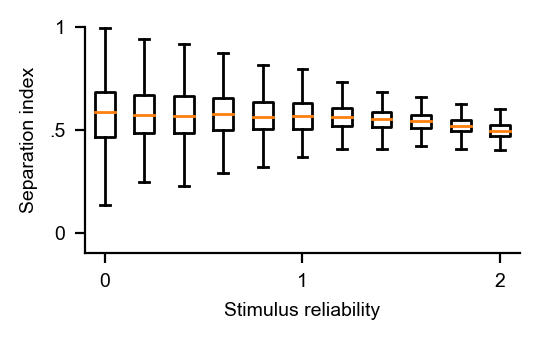

In [56]:
width = 2.5; height = 1.5
yticks = [0, 0.5, 1]
xticks = [0, 1, 2]

fig = plt.figure(figsize=(width, height), dpi=200)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Separation index', fontsize=fontsize)
ax.set_xlabel('Stimulus reliability', fontsize=fontsize)
ax.set_xlim(0-0.1, xticks[-1]+0.1)
ax.set_ylim(0-0.1, 1)
#ax.yaxis.set_label_coords(-0.17, 0.5)
#ax.xaxis.set_label_coords(0.5, -0.17)
ax.yaxis.set_major_formatter(major_formatter)

ydata = [(SI[obs_std]) for obs_std in obs_stds[::-1]]
ax.boxplot(ydata, positions=obs_stds, widths=0.1, showfliers=False)
plt.xticks(xticks, xticks, fontsize=fontsize)
    
fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / '{name}.pdf'.format(name='monk_agent_steer_corr'), orientation='landscape', format='pdf', 
#            transparent=True)

In [69]:
a = np.array(ydata).T

In [75]:
import scipy.io
mat_dict = {'x_si': obs_stds.T, 'y_si': a}
scipy.io.savemat('box_plot.mat', mat_dict)

# 3c

In [76]:
t_end = 900
PL = {}
for obs_std in obs_stds:
    pl_session = []
    for session_idx in range(arg.batch_size):
        cpi_box = []
        for box_idx in range(3):
            pt = np.where(data[obs_std]['actions'][:, session_idx].reshape(-1).numpy() == box_idx)[0]
            cpi = np.arange(t_end)
            bin_indices = np.digitize(cpi, pt)
            pi = np.diff(np.hstack([0, pt]))
            
            for bin_idx in np.unique(bin_indices):
                cpi[bin_indices == bin_idx] = pi[bin_idx]
                
            cpi_box.append(cpi)
            
        #cpi_box_sortidx = np.argsort(np.vstack(cpi_box), axis=0).T
        cpi_box_sortidx = np.argsort(savgol_filter(np.vstack(cpi_box), 90, 1, axis=1), axis=0).T
        pl = []
        for cpi_box_sortidx_t in cpi_box_sortidx:
            pl.append(np.where(cpi_box_sortidx_t == np.array([0, 1, 2]))[0].size)
        pl_session.append(np.array(pl))
    PL[obs_std] = np.vstack(pl_session).T

In [77]:
pl0 = np.vstack([(PL[obs_std] == 0).sum(axis=0) / t_end for obs_std in obs_stds[::-1]])
pl1 = np.vstack([(PL[obs_std] == 1).sum(axis=0) / t_end for obs_std in obs_stds[::-1]])
pl2 = np.vstack([(PL[obs_std] == 3).sum(axis=0) / t_end for obs_std in obs_stds[::-1]])

pl0_mean, pl1_mean, pl2_mean = [v[:, :500].mean(axis=1) for v in [pl0, pl1, pl2]]
pl0_sem, pl1_sem, pl2_sem = [sem(v[:, :500], axis=1) for v in [pl0, pl1, pl2]]

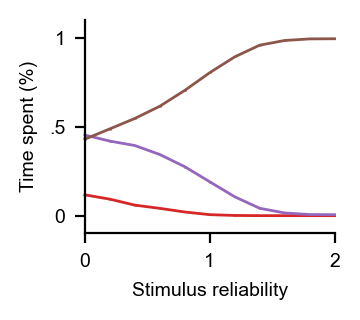

In [78]:
width = 1.6; height = 1.4
yticks = [0, 0.5, 1]
xticks = [0, 1, 2]

fig = plt.figure(figsize=(width, height), dpi=200)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Time spent (%)', fontsize=fontsize)
ax.set_xlabel('Stimulus reliability', fontsize=fontsize)
ax.set_xlim(0, 2)
ax.set_ylim(0-0.1, 1+0.1)
#ax.yaxis.set_label_coords(-0.17, 0.5)
#ax.xaxis.set_label_coords(0.5, -0.17)
ax.yaxis.set_major_formatter(major_formatter)

ax.errorbar(obs_stds, pl0_mean, pl0_sem, lw=1, c='C3', clip_on=False)
ax.errorbar(obs_stds, pl1_mean, pl1_sem, lw=1, c='C4', clip_on=False)
ax.errorbar(obs_stds, pl2_mean, pl2_sem, lw=1, c='C5', clip_on=False)
    
fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / '{name}.pdf'.format(name='monk_agent_steer_corr'), orientation='landscape', format='pdf', 
#            transparent=True)

In [80]:
import scipy.io
mat_dict = {'x_plot':obs_stds, 'y_box1':pl0_mean, 'y_box2':pl1_mean, 'y_box3':pl2_mean,
            'sem_box1': pl0_sem, 'sem_box2':pl1_sem , 'sem_box3':pl2_sem }
scipy.io.savemat('time_spent.mat', mat_dict)

# 3d

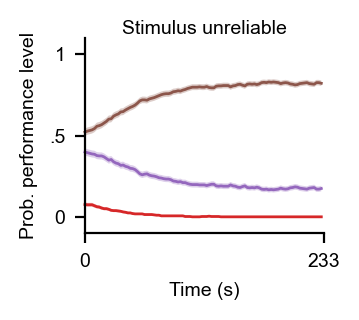

In [112]:
width = 1.6; height = 1.4
yticks = [0, 0.5, 1]
x_end = 100; obs_std = 1.
xticks = np.array([0, x_end])

fig = plt.figure(figsize=(width, height), dpi=200)
ax = fig.add_subplot(111)
ax.set_title('Stimulus unreliable', fontsize=fontsize, pad=0)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, (xticks * yscale).astype(int), fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Prob. performance level', fontsize=fontsize)
ax.set_xlabel('Time (s)', fontsize=fontsize)
ax.set_xlim(0, x_end)
ax.set_ylim(0-0.1, 1+0.1)
#ax.yaxis.set_label_coords(-0.17, 0.5)
#ax.xaxis.set_label_coords(0.5, -0.17)
ax.yaxis.set_major_formatter(major_formatter)

xdata = np.arange(x_end)
for pl, c in zip([0, 1, 3], ['C3', 'C4', 'C5']):
    ydata = (PL[obs_std] == pl).mean(axis=1)[:x_end]
    ysem = sem(PL[obs_std] == pl, axis=1)[:x_end]
    ax.plot(xdata, ydata, lw=1, c=c, clip_on=False)
    ax.fill_between(xdata, ydata - ysem, ydata + ysem,
                    facecolor=c, alpha=0.3)

    
fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / '{name}.pdf'.format(name='monk_agent_steer_corr'), orientation='landscape', format='pdf', 
#            transparent=True)

In [115]:
xplot = xdata
y_box1 = (PL[obs_std] == 0).mean(axis=1)[:x_end]
y_box2 = (PL[obs_std] == 1).mean(axis=1)[:x_end]
y_box3 = (PL[obs_std] == 3).mean(axis=1)[:x_end]

sem_box1 = sem(PL[obs_std] == 0, axis=1)[:x_end]
sem_box2 = sem(PL[obs_std] == 1, axis=1)[:x_end]
sem_box3 = sem(PL[obs_std] == 3, axis=1)[:x_end]

import scipy.io
mat_dict = {'x_plot':xplot, 'y_box1':y_box1, 'y_box2':y_box2, 'y_box3':y_box3,
            'sem_box1': sem_box1, 'sem_box2':sem_box2 , 'sem_box3':sem_box3 }
scipy.io.savemat('performance_prob_unreliable.mat', mat_dict)

4
4
4


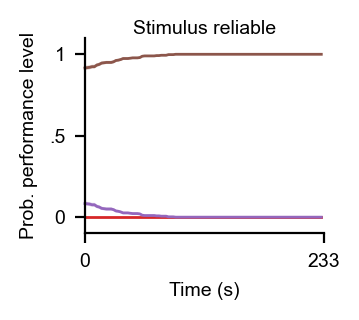

In [116]:
width = 1.6; height = 1.4
yticks = [0, 0.5, 1]
x_end = 100; obs_std = 0
xticks = np.array([0, x_end])

fig = plt.figure(figsize=(width, height), dpi=200)
ax = fig.add_subplot(111)
ax.set_title('Stimulus reliable', fontsize=fontsize, pad=0)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, (xticks * yscale).astype(int), fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Prob. performance level', fontsize=fontsize)
ax.set_xlabel('Time (s)', fontsize=fontsize)
ax.set_xlim(0, x_end)
ax.set_ylim(0-0.1, 1+0.1)
#ax.yaxis.set_label_coords(-0.17, 0.5)
#ax.xaxis.set_label_coords(0.5, -0.17)
ax.yaxis.set_major_formatter(major_formatter)

xdata = np.arange(x_end)
for pl, c in zip([0, 1, 3], ['C3', 'C4', 'C5']):
    ydata = (PL[obs_std] == pl).mean(axis=1)[:x_end]
    ysem = sem(PL[obs_std] == pl, axis=1)[:x_end]
    ax.plot(xdata, ydata, lw=1, c=c, clip_on=False)
    ax.fill_between(xdata, ydata - ysem, ydata + ysem,
                    facecolor=c, alpha=0.3)
    print(i)
    
    
fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / '{name}.pdf'.format(name='monk_agent_steer_corr'), orientation='landscape', format='pdf', 
#            transparent=True)

In [117]:
xplot = xdata
y_box1 = (PL[obs_std] == 0).mean(axis=1)[:x_end]
y_box2 = (PL[obs_std] == 1).mean(axis=1)[:x_end]
y_box3 = (PL[obs_std] == 3).mean(axis=1)[:x_end]

sem_box1 = sem(PL[obs_std] == 0, axis=1)[:x_end]
sem_box2 = sem(PL[obs_std] == 1, axis=1)[:x_end]
sem_box3 = sem(PL[obs_std] == 3, axis=1)[:x_end]

import scipy.io
mat_dict = {'x_plot':xplot, 'y_box1':y_box1, 'y_box2':y_box2, 'y_box3':y_box3,
            'sem_box1': sem_box1, 'sem_box2':sem_box2 , 'sem_box3':sem_box3 }
scipy.io.savemat('performance_prob_reliable.mat', mat_dict)

# decoding

In [25]:
obs_std = 0.6
states = data_delta[obs_std]['states']
true_states = data_delta[obs_std]['true_states']
actions = data_delta[obs_std]['actions']

with torch.no_grad():
    output, _ = agent.model.rnn1(states)

In [26]:
X = torch.flatten(output, 0, 1)
y = torch.flatten(true_states, 0, 1)

model = RidgeCV()
model.fit(X, y)
y_hat = model.predict(X); y_hat = y_hat.reshape(*true_states.shape)

print(model.score(X, y))

0.882722067310934


In [27]:
t_end = 900
box1 = []; box2 = []; box3 = []
box1_shuffle = []; box2_shuffle = []; box3_shuffle = []
for session_idx in range(arg.batch_size):
    cpi_box = []
    for box_idx in range(3):
        pt = np.where(actions[:, session_idx].reshape(-1).numpy() == box_idx)[0]
        cpi = np.arange(t_end)
        bin_indices = np.digitize(cpi, pt)
        pi = np.diff(np.hstack([0, pt]))

        for bin_idx in np.unique(bin_indices):
            cpi[bin_indices == bin_idx] = pi[bin_idx]

        cpi_box.append(cpi)
           
    for box_idx, (box, box_shuffle) in enumerate(zip([box1, box2, box3], [box1_shuffle, box2_shuffle, box3_shuffle])):
        xdata = savgol_filter(cpi_box[box_idx], 90, 1)
        ydata = savgol_filter((true_states-y_hat)[:t_end, session_idx, box_idx], 90, 1)
        ydata_shuffle = ydata.copy(); np.random.shuffle(ydata_shuffle)
        box.append(np.corrcoef(xdata, ydata)[0, 1])
        box_shuffle.append(np.corrcoef(xdata, ydata_shuffle)[0, 1])
        

0.32854091955909
0.5081833571413479
0.6404628689236754


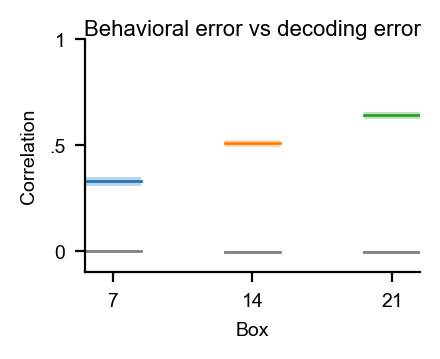

In [28]:
width = 2; height = 1.6
yticks = [0, 0.5, 1]
xticks = [0, 1, 2]; xticklables = [7, 14, 21]

fig = plt.figure(figsize=(width, height), dpi=200)
ax = fig.add_subplot(111)
ax.set_title('Behavioral error vs decoding error', fontsize=fontsize+1, pad=0)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticklables, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Correlation', fontsize=fontsize)
ax.set_xlabel('Box', fontsize=fontsize)
ax.set_xlim(0-0.2, xticks[-1]+0.2)
ax.set_ylim(0-0.1, 1)
#ax.yaxis.set_label_coords(-0.17, 0.5)
#ax.xaxis.set_label_coords(0.5, -0.17)
ax.yaxis.set_major_formatter(major_formatter)

ydata = [box1, box2, box3]
for x, ydata_, c in zip(xticks, ydata, box_cs):
    ymean = np.mean(ydata_)
    print(ymean)
    res = bootstrap((ydata_, ), np.mean, confidence_level=0.95, random_state=0)
    ax.plot([x-0.2, x+0.2], [ymean, ymean], c=c, lw=1)
    ax.fill_between([x-0.2, x+0.2], [res.confidence_interval.low] * 2, [res.confidence_interval.high] * 2, 
                    facecolor=c, alpha=0.3)
    
ydata = [box1_shuffle, box2_shuffle, box3_shuffle]
for x, ydata_ in zip(xticks, ydata):
    ymean = np.mean(ydata_)
    res = bootstrap((ydata_, ), np.mean, confidence_level=0.95, random_state=0)
    ax.plot([x-0.2, x+0.2], [ymean, ymean], c='gray', lw=1)
    ax.fill_between([x-0.2, x+0.2], [res.confidence_interval.low] * 2, [res.confidence_interval.high] * 2, 
                    facecolor='gray', alpha=0.3)
    
fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / '{name}.pdf'.format(name='monk_agent_steer_corr'), orientation='landscape', format='pdf', 
#            transparent=True)

In [31]:
t_end = 900
# change session idx here
session_idx = 0
cpi_box = []; decoding_box = []
for box_idx, ri in enumerate([3, 6, 9]):
    pt = np.where(actions[:, session_idx].reshape(-1).numpy() == box_idx)[0]
    cpi = np.arange(t_end)
    bin_indices = np.digitize(cpi, pt)
    pi = np.diff(np.hstack([0, pt]))

    for bin_idx in np.unique(bin_indices):
        cpi[bin_indices == bin_idx] = pi[bin_idx]

    cpi_box.append(savgol_filter(cpi - cpi.mean(), 90, 1))
    decoding_box.append(savgol_filter((true_states - y_hat)[:t_end, session_idx, box_idx], 90, 1))        

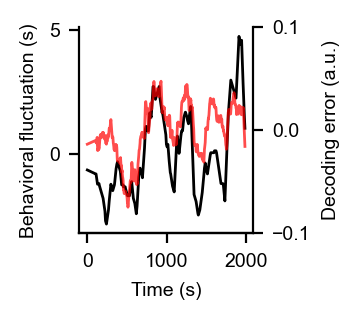

In [32]:
width = 1.6; height = 1.4; box_idx = 2
yticks1 = [-5, 0, 5]; yticks2 = [-0.1, 0, 0.1]
xticks = [0, 1000, 2000]

fig = plt.figure(figsize=(width, height), dpi=200)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks1, fontsize=fontsize)
ax.set_ylabel('Behavioral fluctuation (s)', fontsize=fontsize)
ax.set_xlabel('Time (s)', fontsize=fontsize)
#ax.set_xlim(0, 2)
#ax.set_ylim(yticks1[0], yticks1[-1]+1)
#ax.yaxis.set_label_coords(-0.17, 0.5)
#ax.xaxis.set_label_coords(0.5, -0.17)
#ax.yaxis.set_major_formatter(major_formatter)

xdata = np.arange(t_end) * yscale
ax.plot(xdata[:850], cpi_box[box_idx][:850] * yscale, lw=1, c='k', clip_on=True, alpha=1)

axt = ax.twinx()
axt.spines['top'].set_visible(False); axt.spines['left'].set_visible(False)
plt.yticks(yticks2, fontsize=fontsize)
axt.set_ylabel('Decoding error (a.u.)', fontsize=fontsize)
axt.set_ylim(yticks2[0], yticks2[-1])
axt.plot(xdata[:850], decoding_box[box_idx][:850], lw=1, c='r', clip_on=True, alpha=0.7)
    
fig.tight_layout(pad=0, rect=[0.0, 0, 1.0, 1])
#plt.savefig(figure_path / '{name}.pdf'.format(name='monk_agent_steer_corr'), orientation='landscape', format='pdf', 
#            transparent=True)

In [33]:
t_end = 900
session_idx = 22
cpi_box = []; decoding_box = []
for box_idx, ri in enumerate([3, 6, 9]):
    pt = np.where(actions[:, session_idx].reshape(-1).numpy() == box_idx)[0]
    cpi = np.arange(t_end)
    bin_indices = np.digitize(cpi, pt)
    pi = np.diff(np.hstack([0, pt]))

    for bin_idx in np.unique(bin_indices):
        cpi[bin_indices == bin_idx] = pi[bin_idx]

    cpi_box.append(savgol_filter(cpi - cpi.mean(), 90, 1))
    decoding_box.append(savgol_filter((true_states - y_hat)[:t_end, session_idx, box_idx], 90, 1))        

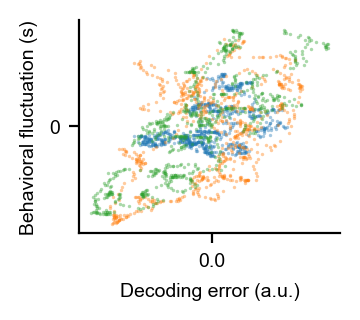

In [34]:
width = 1.6; height = 1.4
yticks = [-5, 0, 5]; xticks = [-0.1, 0, 0.1]

fig = plt.figure(figsize=(width, height), dpi=200)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Behavioral fluctuation (s)', fontsize=fontsize)
ax.set_xlabel('Decoding error (a.u.)', fontsize=fontsize)
#ax.set_xlim(xticks[0], xticks[-1])
#ax.set_ylim(yticks[0], yticks[-1])
#ax.yaxis.set_label_coords(-0.17, 0.5)
#ax.xaxis.set_label_coords(0.5, -0.17)
#ax.yaxis.set_major_formatter(major_formatter)

for box_idx, box_c in enumerate(box_cs):
    ax.scatter( decoding_box[box_idx][100:800], cpi_box[box_idx][100:800] * yscale,
               lw=0, c=box_c, clip_on=True, alpha=0.4, s=1.5)
    
fig.tight_layout(pad=0, rect=[0.0, 0, 1.0, 1])
#plt.savefig(figure_path / '{name}.pdf'.format(name='monk_agent_steer_corr'), orientation='landscape', format='pdf', 
#            transparent=True)

In [118]:
import os
os.getcwd()

'C:\\Users\\Panos\\OneDrive - nyu.edu\\Documents\\PhD Classes\\Machine Learning\\ML_Project\\Code'